In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # 基础绘图库（什么都能画，但可能慢、复杂）
import seaborn as sns # 数据可视化专用库（专门用来快速画数据图）
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram


# 中文字体宋体，英文字体新罗马
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['Times New Roman']
# 字体大小
plt.rcParams['font.size'] = 12  
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_excel('中间数据集\\表1与表2拼接后的数据集.xlsx')
df = df.drop(['采样位置', '纹饰', '表面风化', '颜色', '风化具体情况'], axis=1)
df.head()

,文物编号,类型,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,1,高钾,69.33,0.0,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39
1,2,铅钡,36.28,0.0,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00
2,3,高钾,87.05,0.0,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00
3,3,高钾,61.71,0.0,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00
4,4,高钾,65.88,0.0,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36


In [3]:
df.columns = ['文物编号', '类型', 'SiO2', 'Na2O', 'K2O', 'CaO', 'MgO', 'Al2O3', 'Fe2O3', 
            'CuO', 'PbO', 'BaO', 'P2O5', 'SrO', 'SnO2', 'SO2']
df.head()

,文物编号,类型,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,1,高钾,69.33,0.0,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.0,0.39
1,2,铅钡,36.28,0.0,1.05,2.34,1.18,5.73,1.86,0.26,47.43,0.00,3.57,0.19,0.0,0.00
2,3,高钾,87.05,0.0,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.0,0.00
3,3,高钾,61.71,0.0,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.0,0.00
4,4,高钾,65.88,0.0,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.0,0.36


In [4]:
categories = df["类型"].unique()
category_datasets = {category: pd.DataFrame() for category in categories}

# 遍历原始数据集，并将每个记录分配到相应的类别DataFrame中
for category in categories:
    category_datasets[category] = df[df["类型"] == category]

df1 = category_datasets['高钾'].drop("类型", axis=1)
df2 = category_datasets['铅钡'].drop("类型", axis=1)

In [5]:
names = ['SiO2', 'Na2O', 'K2O', 'CaO', 'MgO', 'Al2O3', 'Fe2O3', 
            'CuO', 'PbO', 'BaO', 'P2O5', 'SrO', 'SnO2', 'SO2']

scaler1 = StandardScaler()
df_1 = pd.DataFrame(scaler1.fit_transform(df1.drop("文物编号", axis=1)))
df_1.columns = names

scaler2 = StandardScaler()
df_2 = pd.DataFrame(scaler2.fit_transform(df2.drop("文物编号", axis=1)))
df_2.columns = names

In [6]:
df_1.head()

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,-0.520223,-0.43792,0.695655,0.769848,0.122877,-0.376814,0.239100,1.182219,-0.549265,-0.487689,0.113832,-0.651608,-0.242536,2.109663
1,0.740167,-0.43792,-0.234901,-0.570776,-1.134808,-0.333336,-0.904200,-0.948533,-0.048922,-0.487689,-0.295964,-0.651608,-0.242536,-0.443757
2,-1.062220,-0.43792,1.157055,0.629876,0.469825,0.148273,0.515069,2.023486,2.272666,3.009000,-0.263823,1.694180,-0.242536,-0.443757
3,-0.765616,-0.43792,0.633618,1.018688,1.120352,0.462657,0.449362,0.016856,-0.549265,-0.487689,-0.191506,-0.651608,-0.242536,1.913246
4,-1.071467,-0.43792,0.881766,1.090229,1.423931,0.817174,0.817320,0.768480,-0.549265,-0.487689,-0.070978,0.755865,-0.242536,2.633441


## ***高钾玻璃亚类划分***

In [7]:
# 使用层次聚类的linkage方法，计算距离矩阵
linked = linkage(df_1, method='ward')
labels_1 = fcluster(linked, t=5, criterion='maxclust')

# 将类别标签加入到原始数据中
df_1['Cluster'] = labels_1
df_1['文物编号'] = df1.reset_index(drop=True)['文物编号']
# df_1 = df_1[['文物编号', 'Cluster']]
df_1.to_excel("结果\\2_2_高钾玻璃亚类划分.xlsx", index=False)

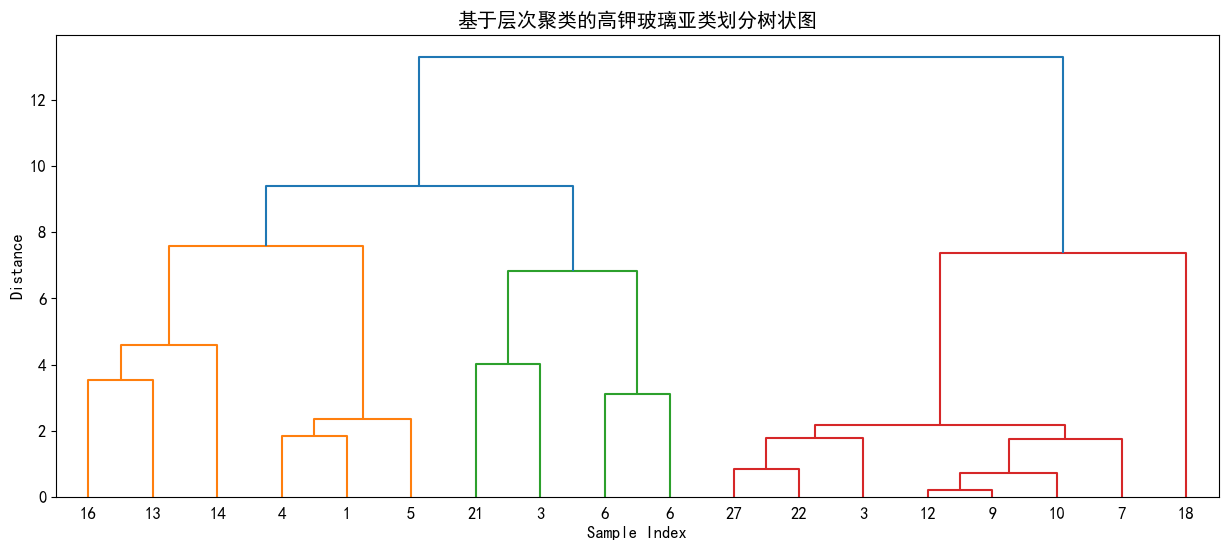

In [8]:
# 绘制树状图
fig, ax = plt.subplots(figsize=(15, 6))
dendrogram(linked, orientation='top', labels=list(df1['文物编号']), distance_sort='descending', 
        show_leaf_counts=True, ax=ax)
ax.set_title('基于层次聚类的高钾玻璃亚类划分树状图')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance')

fig.savefig('图片\\7_高钾玻璃亚类划分树状图.eps')

## ***铅钡玻璃亚类划分***

In [9]:
# 使用层次聚类的linkage方法，计算距离矩阵
linked = linkage(df_2, method='ward')
labels_2 = fcluster(linked, t=5, criterion='maxclust')

# 将类别标签加入到原始数据中
df_2['Cluster'] = labels_2
df_2['文物编号'] = df2.reset_index(drop=True)['文物编号']
# df_2 = df_2[['文物编号', 'Cluster']]
df_2.to_excel("结果\\2_2_铅钡玻璃亚类划分.xlsx", index=False)

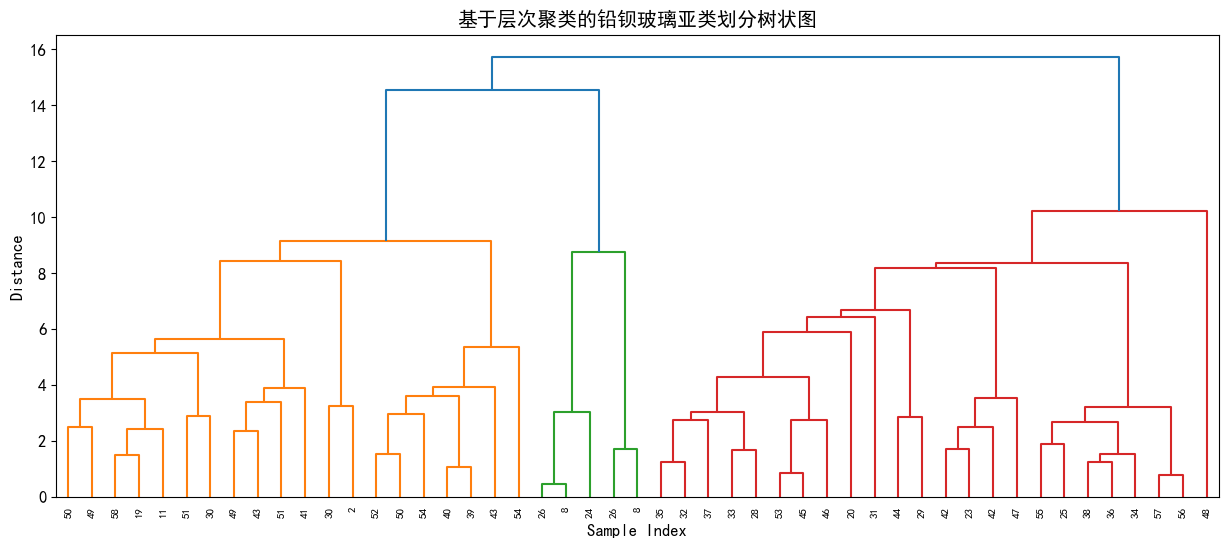

In [10]:
# 绘制树状图
fig, ax = plt.subplots(figsize=(15, 6))
dendrogram(linked, orientation='top', labels=list(df2['文物编号']), distance_sort='descending', 
        show_leaf_counts=True, ax=ax)
ax.set_title('基于层次聚类的铅钡玻璃亚类划分树状图')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance')

fig.savefig('图片\\8_铅钡玻璃亚类划分树状图.eps')

## ***敏感性分析***

In [11]:
from sklearn.metrics import accuracy_score


def add_noise(X, sigma):  
    """在特征X上添加高斯噪声"""  
    return X * (1 + sigma * np.random.randn(*X.shape))

# 定义一个sigma值的范围  
sigmas = np.linspace(0, 0.2, 16)  # 假设我们测试从0到0.5的20个sigma值  
accuracies_1, accuracies_2 = [], []

for sigma in sigmas:  
    df1_noisy = add_noise((df_1.drop(['文物编号', 'Cluster'], axis=1)), sigma)  
    _labels_1 = fcluster(linkage(df1_noisy, method='ward'), t=5, criterion='maxclust')
    accuracy = accuracy_score(_labels_1, labels_1)
    accuracies_1.append(accuracy)

for sigma in sigmas:  
    df2_noisy = add_noise((df_2.drop(['文物编号', 'Cluster'], axis=1)), sigma)  
    _labels_2 = fcluster(linkage(df2_noisy, method='ward'), t=5, criterion='maxclust')
    accuracy = accuracy_score(_labels_2, labels_2)
    accuracies_2.append(accuracy)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


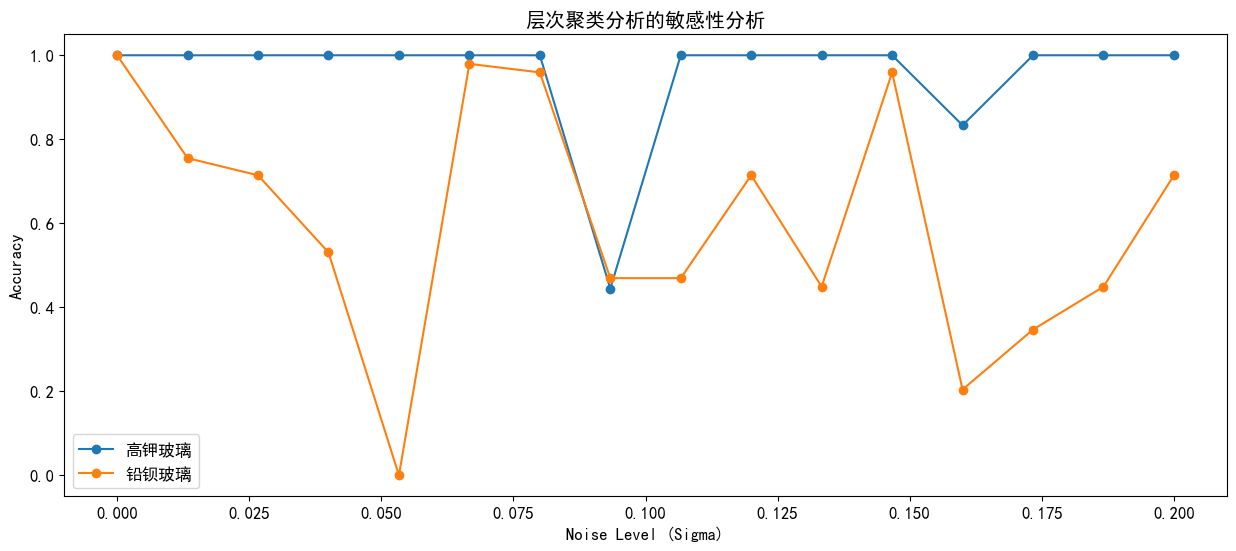

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(sigmas, accuracies_1, marker='o', label='高钾玻璃')  
ax.plot(sigmas, accuracies_2, marker='o', label='铅钡玻璃')  
ax.set_title('层次聚类分析的敏感性分析')  
# ax.set_xticks(sigmas)
ax.set_xlabel('Noise Level (Sigma)')  
ax.set_ylabel('Accuracy')  
ax.legend()

fig.savefig('图片\\9_层次聚类分析的敏感性分析.eps')